# This is for the 5 video tutorial of geoai, to create building footprints using geoai.

In [17]:
import geoai

In [18]:
geoai.__version__ 

'0.5.6'

In [3]:
# define the path of the raster and vector.
raster_url = (
    "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip_train.tif"
)
vector_url = "https://huggingface.co/datasets/giswqs/geospatial/resolve/main/naip_train_buildings.geojson"

In [4]:
# lets download the data set and save it locally.

raster_path = geoai.download_file(raster_url)
vector_path = geoai.download_file(vector_url)


File already exists: naip_train.tif
File already exists: naip_train_buildings.geojson


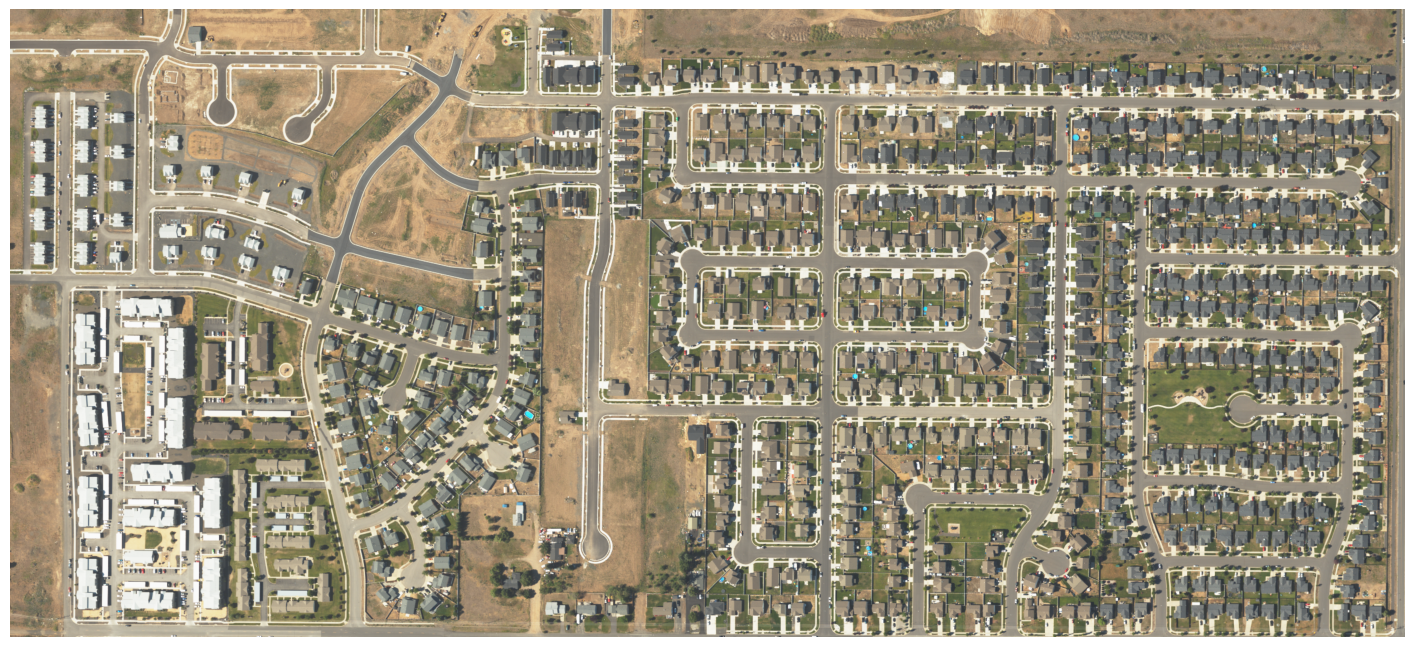

In [5]:
#Viewing the raster image
geoai.view_image(raster_path, figsize=(18, 10))

In [6]:
extractor = geoai.BuildingFootprintExtractor()

Model path not specified, downloading from Hugging Face...
Model downloaded to: C:\Users\USER\.cache\huggingface\hub\models--giswqs--geoai\snapshots\75788bf6253e967a91b9576b1620949a3b939820\building_footprints_usa.pth
Model loaded successfully


In [7]:
# Extract building footprints as vector
output_path = "naip_buildings.gejson"
gdf = extractor.process_raster(
    raster_path,
    output_path ='buildings.geojson',
    batch_size=4,
    confidence_threshold=0.5,
    overlap=0.25,
    nms_iou_threshold=0.5,
    small_building_area=100,
    mask_threshold=0.5,
    simplify_tolerance = 1.0
)

Processing with parameters:
- Confidence threshold: 0.5
- Tile overlap: 0.25
- Chip size: (512, 512)
- NMS IoU threshold: 0.5
- Mask threshold: 0.5
- Min object area: 100
- Max object area: None
- Simplify tolerance: 1.0
- Filter edge objects: True
- Edge buffer size: 20 pixels
Dataset initialized with 3 rows and 7 columns of chips
Image dimensions: 2503 x 1126 pixels
Chip size: 512 x 512 pixels
Overlap: 25.0% (stride_x=384, stride_y=384)
CRS: EPSG:26911
Processing raster with 6 batches


100%|██████████| 6/6 [00:56<00:00,  9.49s/it]


Objects before filtering: 749
Objects after filtering: 749
Saved 749 objects to buildings.geojson


In [8]:
# Regualarize the building footprints
gdf_regularized = extractor.regularize_buildings(
    gdf = gdf,
    min_area=100,
    angle_threshold=15,
    orthogonality_threshold= 0.3,
    rectangularity_threshold=0.7,
)

Regularizing 749 objects...
- Angle threshold: 15° from 90°
- Min orthogonality: 30.0% of angles
- Min rectangularity: 70.0% of bounding box area


100%|██████████| 749/749 [00:00<00:00, 988.48it/s] 

Regularization completed:
- Total objects: 749
- Rectangular objects: 696 (92.9%)
- Other regularized objects: 0 (0.0%)
- Unmodified objects: 53 (7.1%)


In [9]:

gdf.head()

geometry  confidence  class
548   POLYGON ((455272.2 5277763.2, 455271 5277762, ...    0.999945      1
1234  POLYGON ((455984.4 5277643.8, 455983.8 5277643...    0.999941      1
888   POLYGON ((456074.4 5277719.4, 456073.2 5277718...    0.999941      1
549   POLYGON ((455243.4 5277855, 455242.8 5277854.4...    0.999938      1
438   POLYGON ((454989 5277799.2, 454988.4 5277798.6...    0.999931      1

In [10]:
geoai.view_vector_interactive(gdf, column="confidence", layer_name="Building",tiles = "Satellite")

In [16]:
geoai.view_vector_interactive(gdf, column="confidence", layer_name="Buildings", tiles = raster_url)

In [18]:
geoai.view_vector_interactive(
    gdf_regularized, column="confidence", layer_name="Regularized Buildings", tiles=raster_url
)

Using confidence values (range: 0.57 - 1.00)
Visualization saved to naip_buildings.png
Sample visualization saved to naip_buildings_sample.png


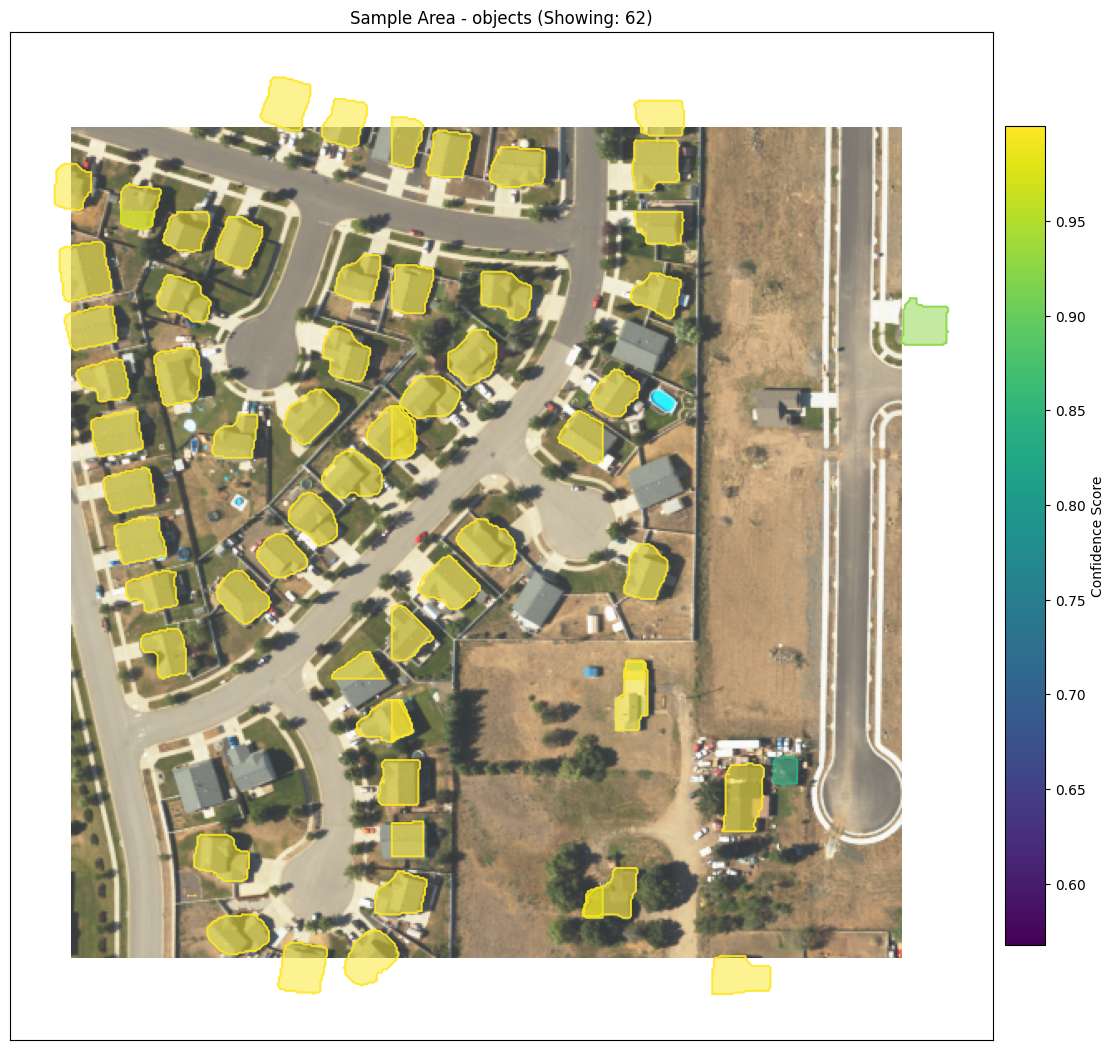

In [19]:
extractor.visualize_results(raster_path,gdf,output_path='naip_buildings.png')

Using confidence values (range: 0.57 - 1.00)
Visualization saved to naip_buildings_regularized.png
Sample visualization saved to naip_buildings_regularized_sample.png


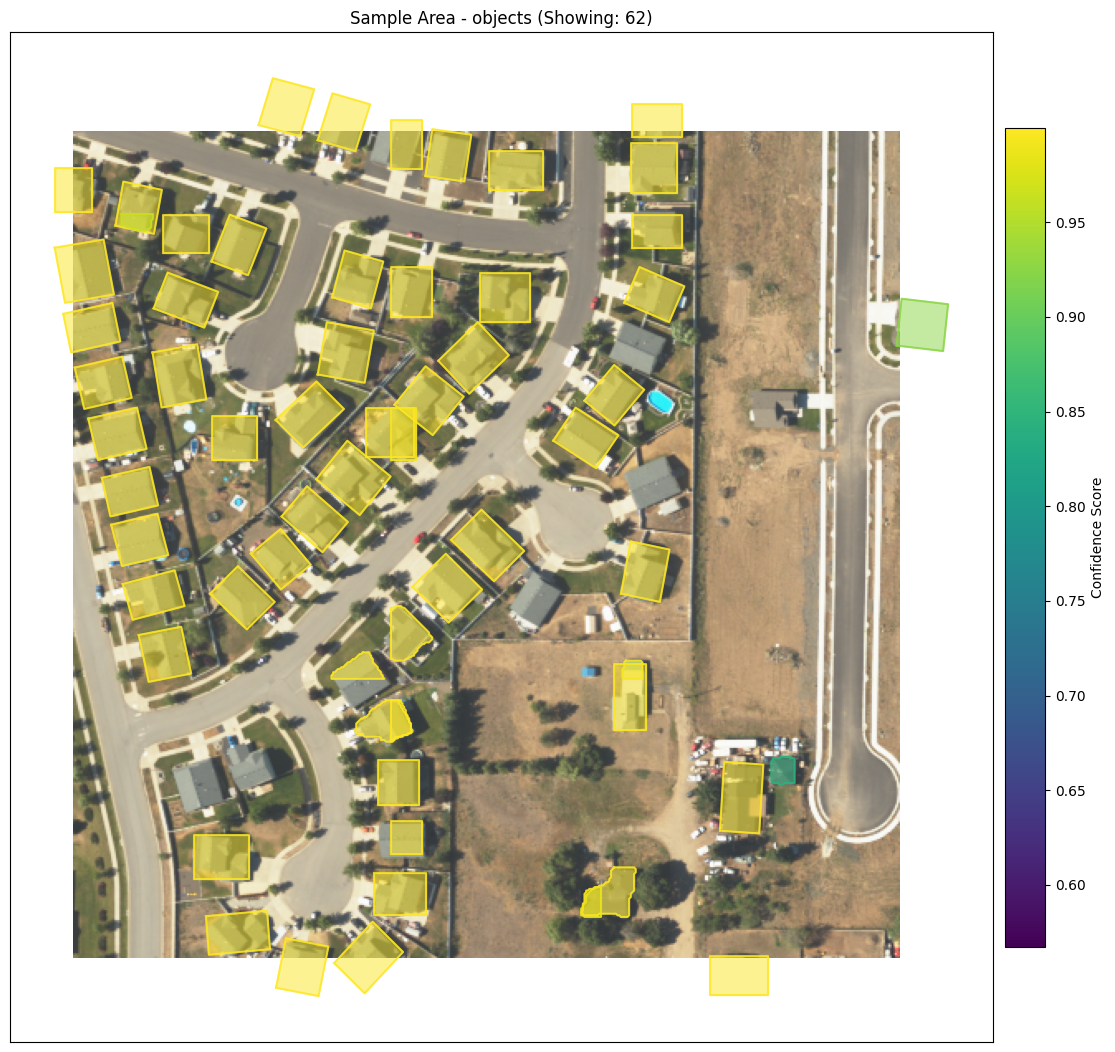

In [21]:
extractor.visualize_results(
    raster_path, gdf_regularized, output_path='naip_buildings_regularized.png'
    )



In [20]:
building_output_path = 'building_mask.tif'
building_mask = extractor.generate_masks(raster_path=raster_path, 
                                         output_path=building_output_path, 
                                         confidence_threshold=0.5,
                                         mask_threshold=0.5,
                                         small_building_area=100,
                                         overlap=0.25,
                                         batch_size=4,
                                            nms_iou_threshold=0.5,
                                            simplify_tolerance=1.0
                                                                                     )

Dataset initialized with 3 rows and 7 columns of chips
Image dimensions: 2503 x 1126 pixels
Chip size: 512 x 512 pixels
Overlap: 25.0% (stride_x=384, stride_y=384)
CRS: EPSG:26911
Processing raster with 6 batches


100%|██████████| 6/6 [00:52<00:00,  8.82s/it]

Masks with confidence values saved to building_mask.tif


In [26]:
geoai.view_raster(building_output_path,layer_name = 'Building Masks',basemap=raster_url, figsize=(18, 10))

In [27]:
gdf_ortho = geoai.orthogonalize(input_path=building_mask,output_path='naip_buildings_ortho.geojson', epsilon = 0.2)

Processing 715 features...


Converting features: 100%|██████████| 715/715 [00:15<00:00, 46.41shape/s]


Saving to naip_buildings_ortho.geojson...
Done!


In [29]:
geoai.view_vector_interactive(
    gdf_ortho,  tiles=raster_url
)